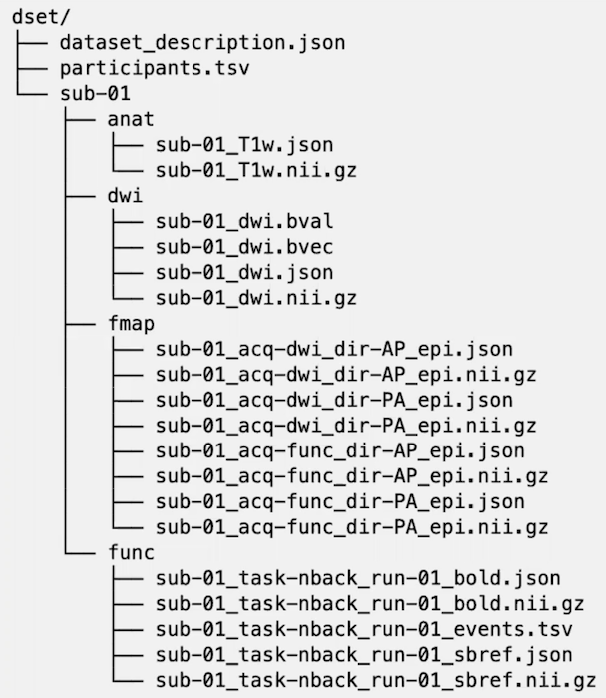

# BIDS: Brain Imaging Data Structure
* BIDS is a directory structure, based on common practices.
* Builds on existing standards (NIfTI, JSON, TSV)
* Intended for human and machine legibility
* The BIDS Validator makes compliance easy to verify
* The specification is a searchable HTML document
* Basic metadata in the file names
    * Subject, seesion, imaging modality, etc.
    * Generally just enough to assign unique names
* NIfTI headers and JSON sidecars contain detailed, image-related metadata.
* dataset_description.json, participants.tsv, sessions.tsv, and scans.tsv record study-level metatdata that may not be associated with specific images.

# Bidsification
* Constructing a BIDS dataset can be tedious and error-prone, so there are several converters.
* DICOM images store their relevant metadata internally, but naming conventions tend to be scanner/institution-specific.
* The Heuristic DICOM Converter (HeuDiConv) and bidsify allow you to specify the mapping and apply in bulk. Both build off of dcm2niix.

## ReproIn
* The ReproIn projects aims to standardize scanner conventions, to eliminate the need to rewrite these mappings.

# BIDS Validator
* The machine-readable structure makes validation possible
* Website validator: https://bids-standard.github.io/bids-validator/

# PyBIDS
* A common specification of neuroimaging datasets affords queries for and adaptation to the available data.
* PyBIDS is a Python library for querying and manipulating BIDS datasets

In [1]:
from bids import BIDSLayout
import nibabel as nib
layout = BIDSLayout('/Users/linweihung/Documents/Python/BrainhackTaiwan/ds000228')
bold = layout.get(subject = 'pixar003', suffix = 'bold', extension = 'nii.gz')
bold

[<BIDSImageFile filename='/Users/linweihung/Documents/Python/BrainhackTaiwan/ds000228/sub-pixar003/func/sub-pixar003_task-pixar_bold.nii.gz'>]

In [ ]:
md = bold[0].get_metadata()
md['RepetitionTime']

In [ ]:
bold[0].get_entities()

In [ ]:
layout.get(subject = 'pixar003')

In [ ]:
# Correct image headers from BIDS metadata
for bold_series in layout.get(suffix='bold', extension='nii.gz'):
    img = bold_series.get_image() #Returns nibabel image object
    zooms = img.header.get_zooms()
    zooms[3] = bold_series.get_metadata()['RepetitionTime']
    img.header.set_zooms(zooms)
    img.to_filename(bold_series)

In [ ]:
layout.get_subjects()

In [ ]:
layout.get_tasks()

In [ ]:
layout.get_suffixes(subject= bids.layout.Query.ANY)

In [ ]:
list(layout.get_entities(metadata=False))

In [ ]:
bold_file = layout.get(subject = 'pixar001', suffix = 'bold',
                       extension = ['nii', 'nii.gz'])[0]
md = bold_file.get_metadata()
md.keys()

In [ ]:
md['EchoTime']

In [ ]:
md['FlipAngle']

Many metadata terms are optional in BIDS, so queries that may work smoothly in one dataset, or on one file, may fail on others:

In [ ]:
md['SliceEncodingDirection']

In [ ]:
layout.get_FlipAngles()

In [ ]:
layout.get_suffix(FlipAngle = 7)

In [ ]:
layout.get_suffix(FlipAngle = 88)

In [ ]:
layout.get_FlipAngle(suffix = 'bold')

In [ ]:
{fa: len(layout.get(FlipAngle = fa))
 for fa in layout.get_FlipAngle(suffix = 'bold')}

In [ ]:
layout.get_subjects(FlipAngle=88)

In [ ]:
layout = BIDSLayout('/Users/linweihung/Documents/Python/BrainhackTaiwan/ds000224')

In [ ]:
participants = layout.get(suffix='participants',extension = 'tsv')[0]
participants

In [ ]:
participants.get_df()

In [ ]:
collections = layout.get_collections(level='dataset')
collections

In [ ]:
collections[0].to_df()

In [ ]:
layout.get_collections(level = 'subject', subject = 'MSC01')[0].to_df()

In [ ]:
layout = BIDSLayout('/Users/linweihung/Documents/Python/BrainhackTaiwan/ds000224')
layout.get_collections(level = 'session', subject = 'MSC01', session = 'func01')[0].to_df()

In [ ]:
layout.get_collections(level='run', subject='MSC01',session = 'func01',
                       task = 'motor', run=1)[0].to_df()

In [ ]:
import json
layout = BIDSLayout('/Users/linweihung/Documents/Python/BrainhackTaiwan/ds000228')
entities = {"task": "rest", "suffix": "bold", "extension": "json"}
layout.build_path(entities)

In [ ]:
layout.write_contents = json.dumps({"Instructions": "Just relax."})

In [ ]:
from bids.reports import BIDSReport
reports = BIDSReport(layout).generate()
print(reports.most_common()[0][0])

In [ ]:
import sys
from pathlib import Path
from bids import BIDSLayout
from bids.reports import BIDSReport

cmd, bids_root, out_root, analysis_level, *opts = sys.argv
layout = BIDSLayout(bids_root)

reports= {}
for subject in layout.get_subjects():
    rep = list(BIDSReport(layout).generate(subject = subject))[0]
    reports.setdefault(rep, []).append(subject)

with open(Path(out_root) / 'report.txt', 'w') as out_file:
    out_file.write(f"Scan parameter sets detected: {len(reports)}\n\n")
    for rep, subs in reports.items():
        rep = "\n".join(rep.splitlines()[:-2])
        out_file.write(f"-----/nParameters for subjects: {', '.join(subs)}\n\n")
        out_file.write(rep.replace('<deg>',"∘") + "\n\n")